<a href="https://colab.research.google.com/github/PravalikaMuthoju/INTERNSHIP-PROJECTS/blob/main/RL_JSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Install dependencies
!pip install stable-baselines3 shimmy gym pandas numpy matplotlib

  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached Shimmy-2.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metada

In [ ]:
# Job Shop Scheduling Problem (JSSP) with Reinforcement Learning (DQN)

# 2) Import libraries
from google.colab import files
import pandas as pd
import numpy as np
import gym
from gym import spaces #actions and observations to be done
from stable_baselines3 import DQN
import matplotlib.pyplot as plt

# 3) Define the JSSP environment
class JSSPEnv(gym.Env):
    def __init__(self, process_time_data, work_order_data):
        super().__init__()  #call a parent class like gym.env
        # Parse process time matrix
        try:
            self.pt = pd.read_csv(process_time_data, index_col=0).astype(int) #reads csv into tables
            print("Process Time Matrix:")
            print(self.pt.head())  # Debug: Show first few rows
            print("Valid Jobs:", set(self.pt.index))
            print("Valid Machines:", set(self.pt.columns.astype(str)))
        except Exception as e:
            raise ValueError(f"Error reading process_time_matrix.csv: {e}")

        # Parse work order
        try:
            wo = pd.read_csv(work_order_data, header=None, usecols=[0, 2], names=['job_id', 'machine_id'])
            print("Work Order (before filtering):")
            print(wo.head())  # Debug: Show first few rows
        except Exception as e:
            raise ValueError(f"Error reading work_order.csv: {e}")

        # Filter valid jobs and machines
        valid_jobs = set(self.pt.index)
        valid_machines = set(self.pt.columns.astype(str))
        self.machines = [int(m) for m in valid_machines]
        wo = wo[wo['job_id'].isin(valid_jobs) & wo['machine_id'].astype(str).isin(valid_machines)]
        print("Work Order (after filtering):")
        print(wo.head())  # Debug: Show filtered work order

        # Build jobs dictionary
        self.jobs = {}
        for job_id in valid_jobs:
            job_ops = wo[wo['job_id'] == job_id]['machine_id'].values
            print(f"Job {job_id} Operations:", job_ops)  # Debug
            operations = []
            for machine in job_ops:
                try:
                    time = self.pt.at[job_id, str(machine)]
                    print(f"Job {job_id}, Machine {machine}: Time {time}")
                    if time != 999999:  # Skip infeasible operations
                        operations.append((int(machine), int(time)))
                except KeyError:
                    print(f"Warning: Machine {machine} not found for Job {job_id} in process_time_matrix")
            if operations:
                self.jobs[job_id] = operations
            print(f"Job {job_id} Valid Operations:", operations)  # Debug

        print("Final Jobs Dictionary:", self.jobs)  # Debug
        if not self.jobs:
            raise ValueError("No valid jobs found in the dataset. Ensure job and machine IDs match and some processing times are not 999999.")

        self.n_jobs = len(self.jobs)
        self.operations_per_job = {j: len(self.jobs[j]) for j in self.jobs}
        self.max_operations = max(self.operations_per_job.values()) if self.operations_per_job else 0

        # State tracking
        self.op_index = {j: 0 for j in self.jobs}  # Current operation index
        self.machine_free = {m: 0 for m in self.machines}  # Machine availability
        self.current_time = 0

        # Action space: Select a job to schedule
        self.action_space = spaces.Discrete(self.n_jobs)
        # Observation space: Job progress and machine availability
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.n_jobs * 2 + len(self.machines),), dtype=np.float32
        )

    def reset(self):
        self.op_index = {j: 0 for j in self.jobs}
        self.machine_free = {m: 0 for m in self.machines}
        self.current_time = 0
        return self._get_observation()

    def _get_observation(self):
        obs = []
        # Job progress: completed and remaining operations
        for job in sorted(self.jobs):
            completed = self.op_index[job] / self.operations_per_job[job]
            remaining = (self.operations_per_job[job] - self.op_index[job]) / self.operations_per_job[job]
            obs.extend([completed, remaining])
        # Machine availability
        max_time = max(self.machine_free.values(), default=1) or 1
        obs.extend([self.machine_free[m] / max_time for m in sorted(self.machines)])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # Map action to job
        job = sorted(self.jobs.keys())[action % self.n_jobs]

        # If job is complete, select first incomplete job
        if self.op_index[job] >= len(self.jobs[job]):
            for j in sorted(self.jobs):
                if self.op_index[j] < len(self.jobs[j]):
                    job = j
                    break
            else:
                return self._get_observation(), 0, True, {"makespan": max(self.machine_free.values())}

        # Schedule operation
        op_idx = self.op_index[job]
        machine, time = self.jobs[job][op_idx]
        start_time = max(self.current_time, self.machine_free[machine])
        end_time = start_time + time
        self.machine_free[machine] = end_time
        self.op_index[job] += 1
        self.current_time = min(self.machine_free.values() or [end_time])

        # Check if done
        done = all(self.op_index[j] >= len(self.jobs[j]) for j in self.jobs)
        makespan = max(self.machine_free.values()) if done else None

        # Reward: Encourage faster completion
        total_ops = sum(self.operations_per_job[j] for j in self.jobs)
        remaining_ops = sum(self.operations_per_job[j] - self.op_index[j] for j in self.jobs)
        reward = 1.0 - (remaining_ops / total_ops) if total_ops > 0 else 1.0

        return self._get_observation(), reward, done, {
            "makespan": makespan,
            "job": job,
            "op_idx": op_idx,
            "start_time": start_time,
            "end_time": end_time,
            "machine": machine
        }

    def render(self, mode="human"):
        print(f"Time: {self.current_time}, Operation Indices: {self.op_index}")

# 4) Main execution
def main():
    try:
        # Clear previous files to avoid conflicts
        !rm -f *.csv

        # Upload dataset files
        print("Please upload process_time_matrix.csv and work_order.csv")
        uploaded = files.upload()
        if len(uploaded) != 2:
            raise FileNotFoundError(f"Expected 2 CSV files, but {len(uploaded)} were uploaded.")

        # Identify process_time_matrix.csv and work_order.csv based on file names
        file_names = list(uploaded.keys())
        process_time_file = next((f for f in file_names if 'process_time_matrix' in f.lower()), None)
        work_order_file = next((f for f in file_names if 'work_order' in f.lower()), None)
        if not process_time_file or not work_order_file:
            raise FileNotFoundError("Could not identify process_time_matrix.csv or work_order.csv")

        # Save files with standard names
        with open('process_time_matrix.csv', 'wb') as f:
            f.write(uploaded[process_time_file])
        with open('work_order.csv', 'wb') as f:
            f.write(uploaded[work_order_file])

        # Initialize environment
        env = JSSPEnv('process_time_matrix.csv', 'work_order.csv')

        # Choose mode
        mode = input("Enter 'train' to train or 'eval' to evaluate: ").strip().lower()

        if mode == "train":
            # Train DQN model
            print("\nTraining with DQN...")
            model = DQN(
                "MlpPolicy",
                env,
                verbose=1,
                learning_rate=1e-3,
                buffer_size=10000,
                exploration_fraction=0.2,
                exploration_final_eps=0.02,
                tensorboard_log="./jssp_logs/"
            )
            model.learn(total_timesteps=50000, log_interval=10)
            model.save("dqn_jssp_model.zip")
            print("✅ Saved dqn_jssp_model.zip")

        elif mode == "eval":
            # Evaluate trained model
            print("\nEvaluating with DQN...")
            try:
                model = DQN.load("dqn_jssp_model.zip")
            except FileNotFoundError:
                raise FileNotFoundError("Model file 'dqn_jssp_model.zip' not found. Please train the model first.")

            obs = env.reset()
            done = False
            schedule = []
            makespans = []
            steps = []
            step = 0

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, _, done, info = env.step(action)
                if "job" in info:
                    schedule.append((
                        info["job"],
                        info["op_idx"],
                        info["start_time"],
                        info["end_time"],
                        info["machine"]
                    ))
                if info["makespan"] is not None:
                    makespans.append(info["makespan"])
                    steps.append(step)
                step += 1
                env.render()

            # Output results
            print("\nEvaluation Results:")
            final_makespan = makespans[-1] if makespans else "N/A"
            print(f"Final Makespan: {final_makespan}")
            print("\nOperation Schedule:")
            for job, op, start, end, machine in schedule:
                print(f"Job {job}, Operation {op}: Machine {machine}, Start {start}, End {end}")

            # Plot makespan
            if makespans:
                plt.figure(figsize=(8, 5))
                plt.plot(steps, makespans, marker='o', color='green', linestyle='-', linewidth=2)
                plt.title("JSSP Makespan Over Steps")
                plt.xlabel("Step")
                plt.ylabel("Makespan")
                plt.grid(True)
                plt.show()

        else:
            print("❌ Invalid choice. Please enter 'train' or 'eval'.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Please upload process_time_matrix.csv and work_order.csv


Saving FT06_Dataset.csv to FT06_Dataset.csv
Error: Expected 2 CSV files, but 1 were uploaded.


Please upload process_time_matrix.csv and work_order.csv


Saving work_order.csv to work_order.csv
Saving process_time_matrix.csv to process_time_matrix.csv
Process Time Matrix (first 5 rows):
          1         2         3         4         5         6         7  \
0                                                                         
1  999999.0      49.0      41.0  999999.0      33.0  999999.0  999999.0   
2  999999.0  999999.0  999999.0  999999.0  999999.0  999999.0  999999.0   
3  999999.0  999999.0  999999.0  999999.0     168.0       6.0  999999.0   
4  999999.0  999999.0  999999.0  999999.0     134.0     297.0  999999.0   
5  999999.0       7.0     620.0  999999.0      35.0  999999.0  999999.0   

          8         9        10  ...        98        99       100       101  \
0                                ...                                           
1  999999.0  999999.0  999999.0  ...  999999.0      21.0      29.0  999999.0   
2  999999.0  999999.0  999999.0  ...  999999.0     178.0  999999.0  999999.0   
3  999999.0  999999.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


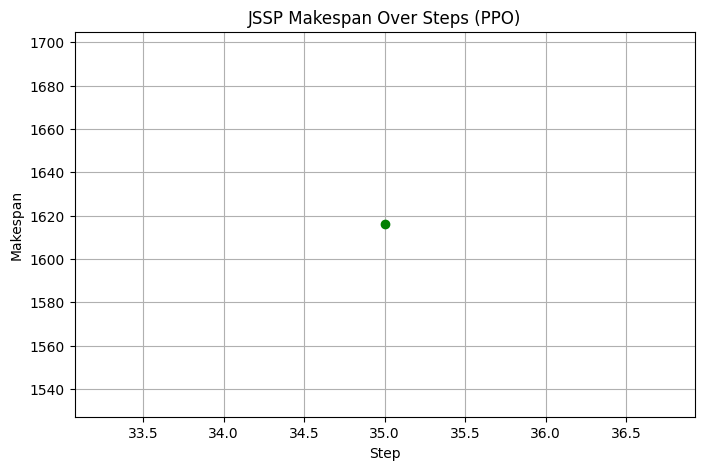

In [ ]:

# Job Shop Scheduling Problem (JSSP) with PPO in Google Colab
# Uploads process_time_matrix.csv and work_order.csv, trains or evaluates a PPO policy
# Outputs makespan, operation schedule, and plot with enhanced exploration

# 1) Install dependencies
!pip install stable-baselines3 shimmy gym pandas numpy matplotlib

# 2) Import libraries
from google.colab import files
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import random
import torch

# 3) Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# 4) Define the JSSP environment
class JSSPEnv(gym.Env):
    def __init__(self, process_time_data, work_order_data, seed=42):
        super().__init__()
        set_seed(seed)
        # Parse process time matrix
        try:
            self.pt = pd.read_csv(process_time_data, index_col=0).astype(float)
            print("Process Time Matrix (first 5 rows):")
            print(self.pt.head())
        except Exception as e:
            raise ValueError(f"Error reading process_time_matrix.csv: {e}")

        # Parse work order
        try:
            wo = pd.read_csv(work_order_data, header=None, usecols=[0, 2], names=['job_id', 'machine_id'])
            print("Work Order (first 5 rows):")
            print(wo.head())
        except Exception as e:
            raise ValueError(f"Error reading work_order.csv: {e}")

        # Filter valid jobs and machines
        valid_jobs = set(self.pt.index)
        valid_machines = set(self.pt.columns.astype(str))
        self.machines = [int(m) for m in valid_machines]
        wo = wo[wo['job_id'].isin(valid_jobs) & wo['machine_id'].astype(str).isin(valid_machines)]

        # Build jobs dictionary
        self.jobs = {}
        for job_id in valid_jobs:
            job_ops = wo[wo['job_id'] == job_id]['machine_id'].values
            operations = []
            for machine in job_ops:
                try:
                    time = self.pt.at[job_id, str(machine)]
                    if time != 999999:
                        operations.append((int(machine), int(time)))
                except KeyError:
                    print(f"Warning: Machine {machine} not found for Job {job_id}")
            if operations:
                self.jobs[job_id] = operations

        if not self.jobs:
            raise ValueError("No valid jobs found. Check job/machine IDs and processing times.")

        self.n_jobs = len(self.jobs)
        self.operations_per_job = {j: len(self.jobs[j]) for j in self.jobs}
        self.max_operations = max(self.operations_per_job.values()) if self.operations_per_job else 0
        self.max_makespan = sum(sum(t for _, t in ops) for ops in self.jobs.values())

        # State tracking
        self.op_index = {j: 0 for j in self.jobs}
        self.machine_free = {m: 0 for m in self.machines}
        self.current_time = 0

        # Define observation and action spaces
        n_features = 2 * self.n_jobs + len(self.machines)
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_features,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.n_jobs)

    def reset(self):
        self.op_index = {j: 0 for j in self.jobs}
        self.machine_free = {m: 0 for m in self.machines}
        self.current_time = 0
        return self._get_observation()

    def _get_observation(self):
        obs = []
        for job in sorted(self.jobs):
            completed = self.op_index[job] / self.operations_per_job[job]
            remaining = (self.operations_per_job[job] - self.op_index[job]) / self.operations_per_job[job]
            obs.extend([completed, remaining])
        max_time = max(self.machine_free.values(), default=1) or 1
        obs.extend([self.machine_free[m] / max_time for m in sorted(self.machines)])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        job = sorted(self.jobs.keys())[action]
        if self.op_index[job] >= len(self.jobs[job]):
            available_jobs = [j for j in self.jobs if self.op_index[j] < len(self.jobs[j])]
            if not available_jobs:
                makespan = max(self.machine_free.values())
                return self._get_observation(), -makespan / self.max_makespan, True, {"makespan": makespan}
            job = random.choice(available_jobs)  # Random fallback

        op_idx = self.op_index[job]
        machine, time = self.jobs[job][op_idx]
        start_time = max(self.current_time, self.machine_free[machine])
        end_time = start_time + time
        self.machine_free[machine] = end_time
        self.op_index[job] += 1
        self.current_time = min(self.machine_free.values() or [end_time])

        done = all(self.op_index[j] >= len(self.jobs[j]) for j in self.jobs)
        makespan = max(self.machine_free.values()) if done else None
        idle_time = sum(max(0, self.current_time - self.machine_free[m]) for m in self.machines)
        reward = -makespan / self.max_makespan - 0.1 * idle_time / self.max_makespan if done else -0.1 * idle_time / self.max_makespan
        if self.op_index[job] == len(self.jobs[job]):
            reward += 0.2  # Job completion bonus

        return self._get_observation(), reward, done, {
            "makespan": makespan,
            "job": job,
            "op_idx": op_idx,
            "start_time": start_time,
            "end_time": end_time,
            "machine": machine
        }

    def render(self, mode="human"):
        print(f"Time: {self.current_time}, Operation Indices: {self.op_index}")

# 5) Main execution with CSV upload
def main():
    try:
        # Clear previous files
        !rm -f *.csv

        # Upload dataset files
        print("Please upload process_time_matrix.csv and work_order.csv")
        uploaded = files.upload()
        if len(uploaded) != 2:
            raise FileNotFoundError(f"Expected 2 CSV files, but {len(uploaded)} uploaded.")

        # Identify and validate files
        file_names = list(uploaded.keys())
        process_time_file = next((f for f in file_names if 'process_time_matrix' in f.lower()), None)
        work_order_file = next((f for f in file_names if 'work_order' in f.lower()), None)
        if not process_time_file or not work_order_file:
            raise FileNotFoundError("Could not identify process_time_matrix.csv or work_order.csv")

        # Save files
        with open('process_time_matrix.csv', 'wb') as f:
            f.write(uploaded[process_time_file])
        with open('work_order.csv', 'wb') as f:
            f.write(uploaded[work_order_file])

        # Initialize environment with random seed
        seed = random.randint(1, 1000)
        env = JSSPEnv('process_time_matrix.csv', 'work_order.csv', seed=seed)

        # Choose mode
        mode = input("Enter 'train' to train or 'eval' to evaluate: ").strip().lower()
        if mode not in ['train', 'eval']:
            raise ValueError("Invalid mode. Enter 'train' or 'eval'.")

        if mode == "train":
            print("\nTraining with PPO...")
            model = PPO(
                "MlpPolicy",
                env,
                verbose=1,
                learning_rate=1e-3,
                n_steps=2048,
                batch_size=32,
                gamma=0.99,
                gae_lambda=0.95,
                clip_range=0.1,
                tensorboard_log="./jssp_logs/"
            )
            model.learn(total_timesteps=100000, log_interval=10, progress_bar=True)
            model.save("ppo_jssp_model.zip")
            print("✅ Saved ppo_jssp_model.zip")

        elif mode == "eval":
            print("\nEvaluating with PPO...")
            try:
                model = PPO.load("ppo_jssp_model.zip")
                print("Model loaded: PPO")
            except FileNotFoundError:
                raise FileNotFoundError("Model file 'ppo_jssp_model.zip' not found. Train first.")

            obs = env.reset()
            done = False
            schedule = []
            makespans = []
            steps = []
            action_log = []
            step = 0

            while not done:
                action, _ = model.predict(obs, deterministic=False)
                obs, reward, done, info = env.step(action)
                action_log.append((step, action, info.get("job")))
                if "job" in info:
                    schedule.append((
                        info["job"],
                        info["op_idx"],
                        info["start_time"],
                        info["end_time"],
                        info["machine"]
                    ))
                if info["makespan"] is not None:
                    makespans.append(info["makespan"])
                    steps.append(step)
                step += 1
                env.render()

            # Output results
            print("\nEvaluation Results:")
            print(f"Final Makespan: {makespans[-1] if makespans else 'N/A'}")
            print("\nOperation Schedule:")
            for job, op, start, end, machine in schedule:
                print(f"Job {job}, Operation {op}: Machine {machine}, Start {start}, End {end}")
            print("\nAction Log (Step, Action, Job):")
            for step, action, job in action_log:
                print(f"Step {step}, Action {action}, Job {job}")

            # Plot makespan
            if makespans:
                plt.figure(figsize=(8, 5))
                plt.plot(steps, makespans, marker='o', color='green', linestyle='-', linewidth=2)
                plt.title("JSSP Makespan Over Steps (PPO)")
                plt.xlabel("Step")
                plt.ylabel("Makespan")
                plt.grid(True)
                plt.show()

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()


Please upload process_time_matrix.csv and work_order.csv


Saving process_time_matrix.csv to process_time_matrix (4).csv
Saving work_order.csv to work_order (2).csv

Training with A2C...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./jssp_a2c_logs/A2C_2


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 36        |
|    ep_rew_mean        | -1.62e+03 |
| time/                 |           |
|    fps                | 430       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -3.46     |
|    explained_variance | 0.936     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.291    |
|    value_loss         | 0.00652   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 36        |
|    ep_rew_mean        | -1.62e+03 |
| time/                 |           |
|    fps                | 377       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/    

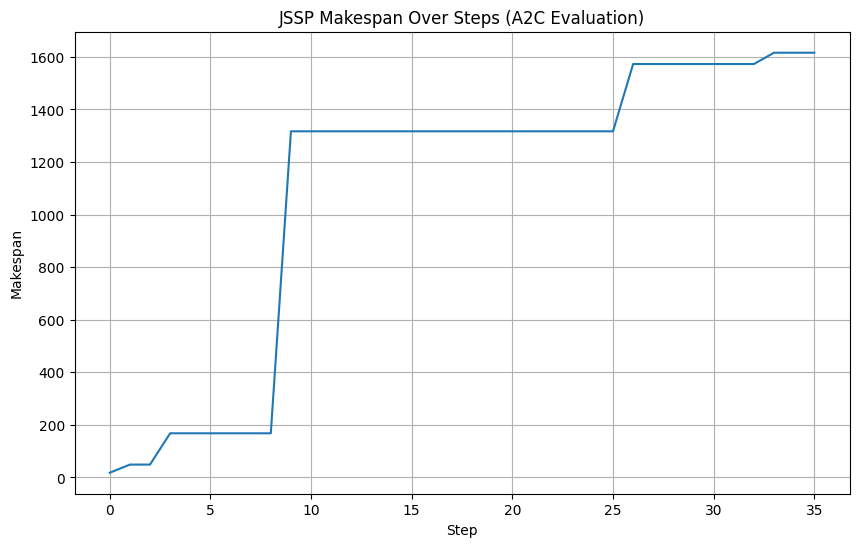

In [ ]:


# 1) Import Libraries
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from google.colab import files
import random # Import random for potential use or consistency

# 2) Upload CSV files (process_time_matrix.csv and work_order.csv)
print("Please upload process_time_matrix.csv and work_order.csv")
uploaded = files.upload()

# Identify and validate files
file_names = list(uploaded.keys())
process_time_file = next((f for f in file_names if 'process_time_matrix' in f.lower()), None)
work_order_file = next((f for f in file_names if 'work_order' in f.lower()), None)

if not process_time_file or not work_order_file:
    raise FileNotFoundError("Could not identify process_time_matrix.csv or work_order.csv")

# Save files with standard names
with open('process_time_matrix.csv', 'wb') as f:
    f.write(uploaded[process_time_file])
with open('work_order.csv', 'wb') as f:
    f.write(uploaded[work_order_file])


# 3) Define the Job Shop Environment
class JobShopEnv(gym.Env):
    def __init__(self, process_time_data, work_order_data):
        super().__init__()
        # Parse process time matrix
        try:
            self.pt = pd.read_csv(process_time_data, index_col=0).astype(float) # Use float as in PPO
            # Get valid machines from the process time matrix columns
            self.machines = sorted([int(m) for m in self.pt.columns.astype(str)])
        except Exception as e:
            raise ValueError(f"Error reading process_time_matrix.csv: {e}")

        # Parse work order
        try:
            # Read only job_id and machine_id columns as in previous examples
            wo = pd.read_csv(work_order_data, header=None, usecols=[0, 2], names=['job_id', 'machine_id'])
        except Exception as e:
            raise ValueError(f"Error reading work_order.csv: {e}")

        # Filter valid jobs and machines based on process time matrix
        valid_jobs = set(self.pt.index)
        valid_machines = set(self.pt.columns.astype(str))
        wo = wo[wo['job_id'].isin(valid_jobs) & wo['machine_id'].astype(str).isin(valid_machines)]

        # Build jobs dictionary: {job_id: [(machine_id, process_time), ...]}
        self.jobs = {}
        for job_id in valid_jobs:
            job_ops = wo[wo['job_id'] == job_id]['machine_id'].values
            operations = []
            for machine in job_ops:
                try:
                    # Ensure machine ID is treated as string for .at lookup if column names are strings
                    time = self.pt.at[job_id, str(machine)]
                    if time != 999999: # Skip infeasible operations
                         # Convert machine ID to int, time should be int based on typical JSSP data
                        operations.append((int(machine), int(time)))
                except KeyError:
                     # Handle cases where a machine listed in work_order isn't in process_time
                    print(f"Warning: Machine {machine} not found for Job {job_id} in process_time_matrix")
                except ValueError:
                    print(f"Warning: Process time for Job {job_id}, Machine {machine} is not an integer.")

            if operations:
                 # Only include jobs that have at least one valid operation
                self.jobs[job_id] = operations

        if not self.jobs:
            raise ValueError("No valid jobs found in the dataset. Ensure job and machine IDs match and some processing times are not 999999.")

        self.job_ids = sorted(list(self.jobs.keys())) # Get sorted job IDs for mapping action to job
        self.n_jobs = len(self.jobs)
        self.operations_per_job = {j: len(self.jobs[j]) for j in self.jobs}
        self.max_operations = max(self.operations_per_job.values()) if self.operations_per_job else 0
        self.n_machines = len(self.machines) # Number of machines

        # State tracking
        # Dictionary mapping job ID to the index of the next operation for that job
        self.op_index = {j: 0 for j in self.jobs}
        # Dictionary mapping machine ID to the time it becomes free
        self.machine_free = {m: 0 for m in self.machines}
        # Current time in the simulation (minimum of machine free times)
        self.current_time = 0
        # Dictionary to store schedule details: {job_id: [(op_idx, machine, start_time, end_time), ...]}
        self.schedule = {j: [] for j in self.jobs}


        # Define observation and action spaces
        # Observation includes job progress (completed/remaining ops) and machine availability
        # Shape: (num_jobs * 2 + num_machines,)
        n_features = self.n_jobs * 2 + self.n_machines
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_features,), dtype=np.float32)
        # Action space is discrete, representing the choice of job to schedule next
        self.action_space = spaces.Discrete(self.n_jobs)

        # Call reset to initialize the environment state
        self.reset()


    def reset(self):
        # Reset state tracking variables
        self.op_index = {j: 0 for j in self.jobs}
        self.machine_free = {m: 0 for m in self.machines}
        self.current_time = 0
        self.schedule = {j: [] for j in self.jobs} # Clear schedule on reset
        # Return initial observation
        return self._get_observation()

    def _get_observation(self):
        obs = []
        # Job progress: completed and remaining operations (normalized)
        for job_id in self.job_ids:
            total_ops = self.operations_per_job[job_id]
            completed = self.op_index[job_id] / total_ops if total_ops > 0 else 1.0
            remaining = (total_ops - self.op_index[job_id]) / total_ops if total_ops > 0 else 0.0
            obs.extend([completed, remaining])
        # Machine availability (normalized by the maximum machine free time)
        max_time = max(self.machine_free.values(), default=1) or 1 # Avoid division by zero
        obs.extend([self.machine_free[m] / max_time for m in sorted(self.machines)])
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # Map action index back to job ID
        job_id = self.job_ids[action % self.n_jobs]

        # Check if the selected job is already complete
        if self.op_index[job_id] >= len(self.jobs[job_id]):
            # If the chosen job is done, find the next available job
            available_jobs = [j for j in self.job_ids if self.op_index[j] < len(self.jobs[j])]
            if not available_jobs:
                # If no jobs are left, the episode is done
                makespan = max(self.machine_free.values())
                # Return observation, a negative reward based on makespan, done=True, and info
                # Using a fixed large penalty for selecting a finished job might be an alternative
                return self._get_observation(), -makespan, True, {"makespan": makespan}
            else:
                 # If available jobs exist, pick the first one or a random one
                 # Here we pick the first available job
                job_id = available_jobs[0]

        # Get the current operation for the chosen job
        op_idx = self.op_index[job_id]
        machine, time = self.jobs[job_id][op_idx]

        # Calculate start and end times for the operation
        # Operation cannot start before the current simulation time or the machine is free
        start_time = max(self.current_time, self.machine_free[machine])
        end_time = start_time + time

        # Update machine free time
        self.machine_free[machine] = end_time
        # Move to the next operation for this job
        self.op_index[job_id] += 1
        # Update the current simulation time (minimum of all machine free times)
        self.current_time = min(self.machine_free.values())

        # Record the scheduled operation
        self.schedule[job_id].append((op_idx, machine, start_time, end_time))

        # Check if all jobs are complete
        done = all(self.op_index[j] >= len(self.jobs[j]) for j in self.job_ids)

        # Calculate makespan if done
        makespan = max(self.machine_free.values()) if done else None

        # Calculate reward: Negative makespan to minimize it.
        # You might add other reward components like idle time penalty or job completion bonus
        reward = -makespan if done else 0 # Simple reward: only gives final makespan as negative reward

        # Return observation, reward, done flag, and info dictionary
        return self._get_observation(), reward, done, {
            "makespan": makespan,
            "job": job_id,
            "op_idx": op_idx,
            "start_time": start_time,
            "end_time": end_time,
            "machine": machine
        }

    def render(self, mode="human"):
        # Basic rendering of the current state
        print(f"Time: {self.current_time}, Operation Indices: {self.op_index}")
        # Optional: print scheduled operations up to current time
        # print("Schedule so far:")
        # for job_id in sorted(self.schedule.keys()):
        #     for op_idx, machine, start, end in self.schedule[job_id]:
        #         if end <= self.current_time:
        #              print(f"  Job {job_id}, Op {op_idx} (Machine {machine}): {start} - {end}")


# 4) Load data and Initialize environment

# 5) Main execution
def main():
    try:
        # Environment initialization is now after file upload

        # Initialize environment
        env = JobShopEnv('process_time_matrix.csv', 'work_order.csv')

        # Initialize and train A2C model
        print("\nTraining with A2C...")
        model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="./jssp_a2c_logs/")
        model.learn(total_timesteps=50000)
        model.save("a2c_jssp_model.zip")
        print("✅ Saved a2c_jssp_model.zip")


        # 6) Evaluate the trained model
        print("\nEvaluating with A2C...")
        try:
            model = A2C.load("a2c_jssp_model.zip")
            print("Model loaded: A2C")
        except FileNotFoundError:
            print("Model file 'a2c_jssp_model.zip' not found. Train first.")
            return # Exit if model not found for evaluation


        obs = env.reset()
        done = False
        makespans = []
        steps = []
        step = 0
        schedule_details = [] # Store schedule details for output

        print("\nStarting Evaluation Steps...")
        while not done:
            # Use deterministic=True for evaluation usually
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)

            # Collect schedule details from info dictionary
            if "job" in info:
                 schedule_details.append((
                    info["job"],
                    info["op_idx"],
                    info["start_time"],
                    info["end_time"],
                    info["machine"]
                 ))

            # makespan is only in info when done=True, or if you add it in step
            # Let's track makespan over steps if it's available, otherwise only the final one
            current_makespan = max(env.machine_free.values()) # Calculate current makespan
            makespans.append(current_makespan)
            steps.append(step)

            step += 1
            # env.render() # Optional: render step-by-step progress

        # Output results
        print("\nEvaluation Results:")
        final_makespan = makespans[-1] if makespans else "N/A"
        print(f"Final Makespan: {final_makespan}")
        print("\nOperation Schedule:")
        # Sort schedule by start time for clearer output
        schedule_details.sort(key=lambda x: x[2])
        for job, op, start, end, machine in schedule_details:
            print(f"Job {job}, Operation {op}: Machine {machine}, Start {start}, End {end}")


        # 7) Plot Makespan Trend
        if makespans:
            plt.figure(figsize=(10, 6))
            plt.plot(steps, makespans)
            plt.title("JSSP Makespan Over Steps (A2C Evaluation)")
            plt.xlabel("Step")
            plt.ylabel("Makespan")
            plt.grid(True)
            plt.show()
        else:
            print("No makespan data to plot.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except ValueError as e:
        print(f"Configuration Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        # import traceback
        # traceback.print_exc() # Uncomment for more detailed error info


if __name__ == "__main__":
    main()